## Проект "Поездки на такси в Нью-Йорке"

### Цель проекта:  
- рассчитать процент поездок по каждому дню в зависимости от числа пассажиров (в разрез 1, 2, 3, 4 и более человек) 
- проанализировать зависимость размера чаевых от числа пассажиров и дальности поездки

### Загрузка и изучение исходных данных 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# %%timeit
df = pd.read_csv('./data/yellow_tripdata_2020-01.csv', sep=',', low_memory=False)

In [4]:
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 879.6+ MB


In [6]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [7]:
df['date_trip'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.date

In [8]:
df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date_trip
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,2020-01-01
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,2020-01-01
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,2020-01-01


### Анализ качества данных

**Качество данных**
- период ограничиваем период январем 2020г
- отрицательные суммы меняем знак 
- удалить пустые и нулевые по тотал сумме поездки, расстоянию и числу пассажиров
- удалить поездки с длительностью менее 3-х минут
- удалить поездки с расстоянием менее 0,5 км/миль
- проверить и удалить дубликаты
<!-- - удалить выбросы:
    - ниже 5 и выше 95 перцентиля -->

In [9]:
date_st = dt.date(2020,1,1)
date_end = dt.date(2020,1,31)

min_lim = pd.Timedelta(minutes=3)

In [10]:
df['total_amount'] = np.where(df['total_amount'] < 0, 
                              -df['total_amount'], 
                              df['total_amount'])

In [11]:
df['trip_distance'] = np.where(df['trip_distance'] < 0, 
                              -df['trip_distance'], 
                              df['trip_distance'])

In [12]:
df['lenth_trip'] = pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])

In [13]:
df = df.drop_duplicates()

In [14]:
df_corr = df.query('(date_trip >= @date_st) \
                & (date_trip <= @date_end)\
                & (total_amount > 0)\
                & (lenth_trip > @min_lim)\
                & (trip_distance > 0.5)'
             )

In [15]:
df_corr.dropna(subset=['total_amount', 'passenger_count','trip_distance'], inplace=True)

C:\Users\piggy\AppData\Local\Temp/ipykernel_20104/1606028731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr.dropna(subset=['total_amount', 'passenger_count','trip_distance'], inplace=True)


группировка по числу пассажиров в поездке

In [16]:
def count_passengers(row):
    row = row['passenger_count']
    if row == 0:
        return 'percentage_zero'
    if row == 1:
        return 'percentage_1p'
    if row == 2:
        return 'percentage_2p'
    if row == 3:
        return 'percentage_3p'
    else:
        return 'percentage_4p_plus'

In [17]:
df_corr['cnt_pass'] = df_corr.apply(count_passengers, axis=1)

C:\Users\piggy\AppData\Local\Temp/ipykernel_20104/365501715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['cnt_pass'] = df_corr.apply(count_passengers, axis=1)


### Группировка по числу пассажиров согласно бизнес-требований

In [18]:
df_group = pd.pivot_table(df_corr, 
                          index='date_trip', 
                          values='VendorID', 
                          columns='cnt_pass' , 
                          aggfunc='count')

In [19]:
df_group.head(3)

cnt_pass,percentage_1p,percentage_2p,percentage_3p,percentage_4p_plus,percentage_zero
date_trip,,,,,
2020-01-01,97002,30105,8933,15147,2257
2020-01-02,100115,23704,7082,13096,2426
2020-01-03,113781,27408,7697,14276,2819


In [20]:
df_group_share = df_group.div(df_group.sum(axis=1), axis=0).round(2).reset_index().rename_axis(None, axis=1) 

In [21]:
df_group_share.head(3)

,date_trip,percentage_1p,percentage_2p,percentage_3p,percentage_4p_plus,percentage_zero
0,2020-01-01,0.63,0.20,0.06,0.10,0.01
1,2020-01-02,0.68,0.16,0.05,0.09,0.02
2,2020-01-03,0.69,0.17,0.05,0.09,0.02


In [22]:
df_min_max = pd.pivot_table(df_corr, 
                            index='date_trip', 
                            values='total_amount', 
                            columns='cnt_pass' , 
                            aggfunc=['min', 'max']).reset_index()

In [23]:
df_min_max.head(5)

date_trip           min                              \
cnt_pass             percentage_1p percentage_2p percentage_3p   
0         2020-01-01           0.3          0.30          0.31   
1         2020-01-02           0.3          0.30          0.30   
2         2020-01-03           0.3          0.31          5.30   
3         2020-01-04           0.3          0.30          0.30   
4         2020-01-05           0.3          0.30          0.31   

                                                      max                \
cnt_pass percentage_4p_plus percentage_zero percentage_1p percentage_2p   
0                       5.3             0.3        465.30        281.42   
1                       4.8             5.3        390.96        210.65   
2                       4.8             5.3       1242.30        370.30   
3                       4.8             0.3        340.54        481.30   
4                       5.3             5.3        596.42        344.29   

                                                           
cnt_pass percentage_3p percentage_4p_plus percentage_zero  
0               433.04             350.42          145.55  
1               215.54             352.30          162.42  
2               409.59             215.30          187.42  
3               158.80             577.80          152.54  
4               333.34             255.42          435.42

### Формирование итогового DF (группровка, добавление минимальных и максимальных значений)

In [24]:
df_big = pd.merge(df_group_share, df_min_max, on='date_trip')

C:\Users\piggy\AppData\Local\Temp/ipykernel_20104/457234710.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_big = pd.merge(df_group_share, df_min_max, on='date_trip')
C:\Users\piggy\AppData\Local\Temp/ipykernel_20104/457234710.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_big = pd.merge(df_group_share, df_min_max, on='date_trip')


In [25]:
df_big.head(1)

,date_trip,percentage_1p,percentage_2p,percentage_3p,percentage_4p_plus,percentage_zero,"(min, percentage_1p)","(min, percentage_2p)","(min, percentage_3p)","(min, percentage_4p_plus)","(min, percentage_zero)","(max, percentage_1p)","(max, percentage_2p)","(max, percentage_3p)","(max, percentage_4p_plus)","(max, percentage_zero)"
0,2020-01-01,0.63,0.2,0.06,0.1,0.01,0.3,0.3,0.31,5.3,0.3,465.3,281.42,433.04,350.42,145.55


In [26]:
new_names = {('min', 'percentage_1p'):"min_percentage_1p",
 ('min', 'percentage_2p'):'min_percentage_2p',
 ('min', 'percentage_3p'): 'min_percentage_3p',
 ('min', 'percentage_4p_plus'):'min_percentage_4p_plus',
 ('min', 'percentage_zero'):'min_percentage_zero',   
 ('max', 'percentage_1p'): 'max_percentage_1p',
 ('max', 'percentage_2p'): 'max_percentage_2p', 
 ('max', 'percentage_3p'): 'max_percentage_3p',
 ('max', 'percentage_4p_plus'): 'max_percentage_4p_plus',
 ('max', 'percentage_zero'):'max_percentage_zero'}

In [27]:
df_big.rename(columns=new_names, inplace=True)

### Выгрузка итоговых данных в parquet файл

In [28]:
!pip install pyarrow

In [29]:
df_big.to_parquet('./data/output_df.parquet')

In [37]:
df_big.columns

Index(['date_trip', 'percentage_1p', 'percentage_2p', 'percentage_3p',
       'percentage_4p_plus', 'percentage_zero', 'min_percentage_1p',
       'min_percentage_2p', 'min_percentage_3p', 'min_percentage_4p_plus',
       'min_percentage_zero', 'max_percentage_1p', 'max_percentage_2p',
       'max_percentage_3p', 'max_percentage_4p_plus', 'max_percentage_zero'],
      dtype='object')

### Проверка выгрузки из файла

In [30]:
df_read = pd.read_parquet('./data/output_df.parquet')  

df_read.head(2)

,date_trip,percentage_1p,percentage_2p,percentage_3p,percentage_4p_plus,percentage_zero,min_percentage_1p,min_percentage_2p,min_percentage_3p,min_percentage_4p_plus,min_percentage_zero,max_percentage_1p,max_percentage_2p,max_percentage_3p,max_percentage_4p_plus,max_percentage_zero
0,2020-01-01,0.63,0.20,0.06,0.10,0.01,0.3,0.3,0.31,5.3,0.3,465.30,281.42,433.04,350.42,145.55
1,2020-01-02,0.68,0.16,0.05,0.09,0.02,0.3,0.3,0.30,4.8,5.3,390.96,210.65,215.54,352.30,162.42


### Визуализация зависимости размера чаевых от количества пассажиров

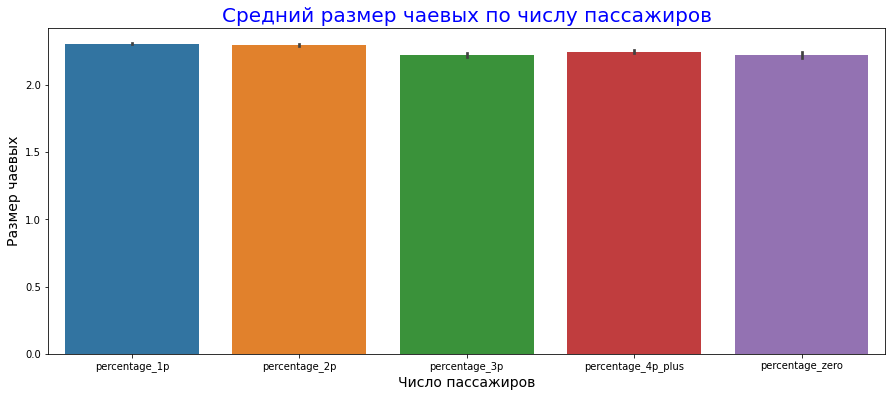

In [31]:
plt.figure(figsize=(15,6))
sns.barplot(y='tip_amount', x='cnt_pass', data=df_corr)
plt.title('Средний размер чаевых по числу пассажиров', size=20, c='b')
plt.xlabel('Число пассажиров', size=14)
plt.ylabel('Размер чаевых', size=14)
plt.show()

Наибольший средний размер чаевых по поездкам с одним и двумя пассажирами.

### Визуализация зависимости размера чаевых от расстояния поездки

In [32]:
df_corr['group_distance'] =  pd.cut(df_corr.trip_distance, 8, precision=1)

C:\Users\piggy\AppData\Local\Temp/ipykernel_20104/3920552708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['group_distance'] =  pd.cut(df_corr.trip_distance, 8, precision=1)


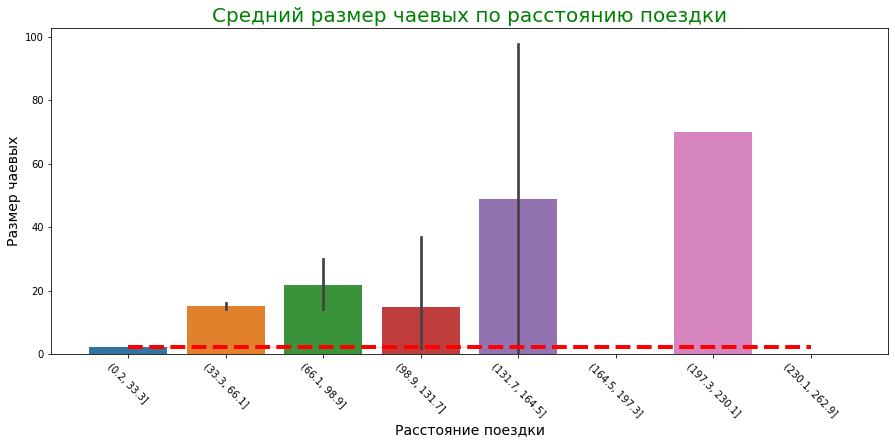

In [33]:
plt.figure(figsize=(15,6))

sns.barplot(y='tip_amount', x='group_distance', data=df_corr)
plt.title('Средний размер чаевых по расстоянию поездки', size=20, c='g')
plt.xlabel('Расстояние поездки', size=14)
plt.ylabel('Размер чаевых', size=14)
plt.xticks(rotation=-45)
sns.lineplot(data=df_corr, 
             x=df_corr['group_distance'].astype('str'), 
             y= df_corr['tip_amount'].mean(), 
             color='r', 
             lw = 4,
             linestyle='--'
            )

plt.show()

Наибольший средний размер чаевых у поездок с дальностью 197-230 км/миль. Причем отчетливо заметна зависимость при увеличении дальности увеличивается средний размер чаевых. Однако часть групп представлена слишком малым числом поездок (менее 5), значения суммы чаевых в них отсутвуют.  
Для наглядности добавлена линия средней суммы чаевых по всему DF, ее значение показывает, что основное влияние на среднюю у группы 0-33 км/миль. Ниже построены диаграммы распределения значений для подтверждения этого и выведены данные о количестве записей по каждой группе.

In [34]:
df_corr['group_distance'].astype('str').value_counts()

(0.2, 33.3]       5796115
(33.3, 66.1]         1921
(66.1, 98.9]           80
(98.9, 131.7]          14
(230.1, 262.9]          3
(131.7, 164.5]          2
(164.5, 197.3]          1
(197.3, 230.1]          1
Name: group_distance, dtype: int64

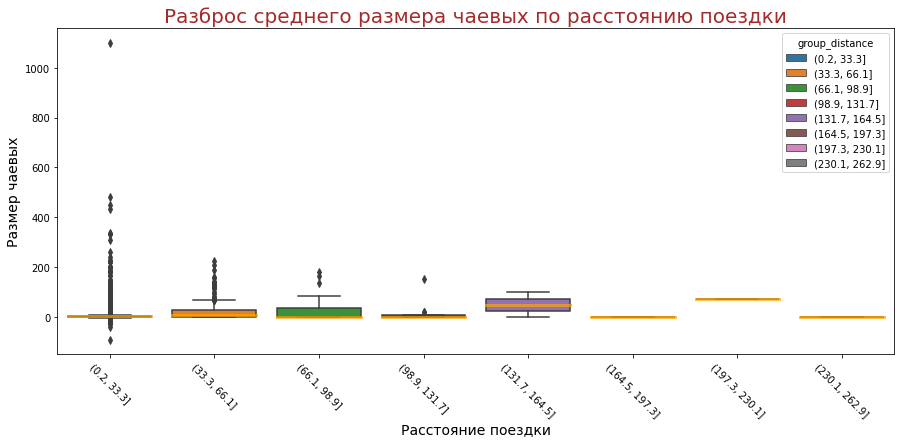

In [35]:
plt.figure(figsize=(15,6))

sns.boxplot(data=df_corr,
            y='tip_amount', x='group_distance', 
            medianprops=dict(color="orange", alpha=0.7, lw=3),
            hue='group_distance',
            dodge=False
           )
plt.title('Разброс среднего размера чаевых по расстоянию поездки', size=20, c='brown')
plt.xlabel('Расстояние поездки', size=14)
plt.ylabel('Размер чаевых', size=14)
plt.xticks(rotation=-45)


plt.show()